## Global optimum using gradient descent and analytic model

In [1]:
%reload_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
from spice_net import *
from helpers import *
import torch
from torch.autograd import Variable
from torch.nn import MSELoss
import matplotlib.pyplot as plt

In [2]:
# Fixed parameters
nodes = 8
edge_prob = 1.

in_nodes = 2
out_nodes = 1

In [3]:
con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=False)
weights = np.abs(np.random.normal(1, 0.5, size=con_graph.number_of_edges()))

for i, (u, v) in enumerate(con_graph.edges()):
    con_graph[u][v]['type'] = 'resistor'
    con_graph[u][v]['weight'] = weights[i]

node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

out_plus = node_cfg[1][0][0]
out_minus = node_cfg[1][0][1]

net = LinearNetwork('test', con_graph, node_cfg)

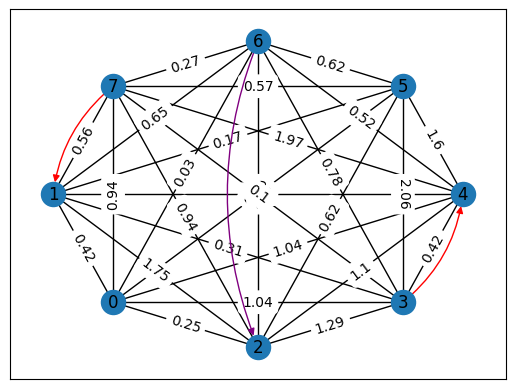

In [4]:
visualize(net)

In [5]:
# Generate the uniform inputs 
num_pts = 40
lh = 2

xs = np.linspace(-lh, lh, num_pts)[:, None]
xs_bias = np.hstack((xs, np.ones(xs.shape)))

In [6]:
# Generate target outputs
weights = np.random.normal(0, 1, size=(2, 1))
ys = xs_bias @ weights

In [7]:
np.clip(weights, -1, 1)

array([[-0.11282729],
       [-0.09081847]])

In [8]:
def analytic_solve(net: LinearNetwork, inputs, targets, optimizer, iters=100):
    # construct the model and circuit matrix
    n = len(net.__nodes__[1:])
    m = len(net.inputs)
    B = np.zeros((n, m))
    C = B.T
    D = np.zeros((m, m))
    
    # populate G with resistor values
    M = []
    r = Variable(torch.ones(len(net.edges)), requires_grad=True)
    for i, R in enumerate(net.edges):
        i, j = list(map(lambda i: int(i)-1, R.node_names))
        mat = np.zeros((m+n, m+n))
        if min(i, j) >= 0:
            mat[i, j] = mat[j, i] = -1

            mat[i, i] = 1
            mat[j, j] = 1
        else:
            mat[max(i, j), max(i, j)] = 1
        
        M.append(mat)
    M = torch.Tensor(np.array(M))

    for k, V in enumerate(net.inputs):
        i, j = list(map(lambda i: int(i)-1, V.node_names))
        if i >= 0:
            B[i, k] = 1
        if j >= 0:
            B[j, k] = -1

    constant_part = torch.Tensor(np.block([[np.zeros((n, n)), B], [C, D]]))

    # prepare the data matrices
    n_examples = inputs.shape[0]
    output_dim = targets.shape[1]

    inputs = inputs.T
    targets = targets.T

    downsampler = torch.zeros((output_dim, m+n),  requires_grad=False)

    for k, V in enumerate(net.outputs):
        i, j = list(map(lambda i: int(i)-1, V.node_names))
        downsampler[k, i] = 1
        downsampler[k, j] = -1
    
    X = torch.Tensor(np.concatenate((np.zeros((n, n_examples)), inputs)))
    targets = torch.Tensor(targets)

    mse = MSELoss()

    # do the optimization
    optim = optimizer([r], lr=0.01)
    alpha = 1e-5

    losses = []

    for i in range(iters):
        A = constant_part + torch.einsum('a...,a->...', M, r)
        preds = downsampler @ torch.linalg.solve(A, X)

        loss = mse(preds, targets) + torch.sum(torch.maximum(-alpha*r, torch.zeros(r.shape)))
        losses.append(loss.detach())
        optim.zero_grad()
        loss.backward()
        optim.step()

        alpha = min(10*alpha, 1e5)

    return r.detach(), A.detach(), downsampler, losses

In [9]:
r_star, A_star, downsampler, losses = analytic_solve(net, xs_bias, ys, torch.optim.SGD, 1000)

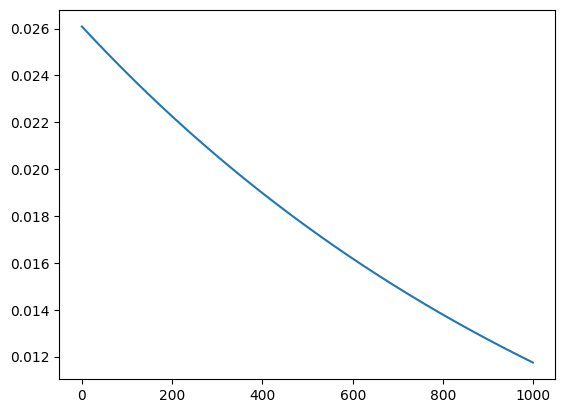

In [10]:
plt.plot(losses)

In [81]:
(downsampler @ np.linalg.solve(A_star.detach(), np.concatenate((np.zeros((A_star.shape[1]-xs_bias.shape[1], xs_bias.shape[0])), xs_bias.T)))).squeeze()

tensor([-0.4895, -0.4656, -0.4417, -0.4178, -0.3939, -0.3700, -0.3461, -0.3222,
        -0.2983, -0.2744, -0.2505, -0.2266, -0.2027, -0.1788, -0.1549, -0.1310,
        -0.1071, -0.0832, -0.0593, -0.0354, -0.0115,  0.0124,  0.0363,  0.0602,
         0.0841,  0.1080,  0.1320,  0.1559,  0.1798,  0.2037,  0.2276,  0.2515,
         0.2754,  0.2993,  0.3232,  0.3471,  0.3710,  0.3949,  0.4188,  0.4427],
       dtype=torch.float64)

In [82]:
ys.squeeze()

array([-1.16194466, -1.10603727, -1.05012988, -0.9942225 , -0.93831511,
       -0.88240772, -0.82650033, -0.77059295, -0.71468556, -0.65877817,
       -0.60287078, -0.5469634 , -0.49105601, -0.43514862, -0.37924123,
       -0.32333385, -0.26742646, -0.21151907, -0.15561169, -0.0997043 ,
       -0.04379691,  0.01211048,  0.06801786,  0.12392525,  0.17983264,
        0.23574003,  0.29164741,  0.3475548 ,  0.40346219,  0.45936958,
        0.51527696,  0.57118435,  0.62709174,  0.68299913,  0.73890651,
        0.7948139 ,  0.85072129,  0.90662868,  0.96253606,  1.01844345])

In [85]:
weights

array([[ 0.54509703],
       [-0.0717506 ]])

In [86]:
r_star

tensor([1.0000, 1.7074, 1.0000, 1.0000, 1.0000, 0.1211, 1.0000, 0.9939, 1.0000,
        1.0000, 1.0000, 0.8345, 1.0000, 0.8345, 0.1211, 0.9142, 0.6569, 0.9142,
        1.0000, 1.0000, 0.9939, 1.0000, 1.0000, 1.7074, 1.0000, 0.9142, 1.0000,
        0.9142])